<a href="https://colab.research.google.com/github/bchuchucaa/RNNConsumoDeAgua/blob/main/LstmWaterConsumption1990_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Universidad Politecnica Salesiana

LSTM para prediccion del consumo de agua


In [7]:
!pip install keras-tuner
!pip3 install datapane

# IMPORTACION DE LIBRERIAS

In [8]:
import pandas as pd
import numpy as np
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,RepeatVector,TimeDistributed, GRU, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow import keras
#Librerias para graficos
import plotly
#import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import pyplot
#Manejo de fechas
from datetime import datetime
from pandas.tseries.offsets import MonthBegin,MonthEnd

print('LIBRERIAS CORRECTAMENTE IMPORTADAS')

LIBRERIAS CORRECTAMENTE IMPORTADAS


##Lectura de datos

In [9]:
df_cpu_pivot = pd.read_csv('/content/1990-2021.csv')
df_cpu_pivot = df_cpu_pivot.rename(columns={'United States(USD)':'Jimmy Magguill','Europe(EUR)':'Michael Hermantrout','Japan(JPY)':'Kim Yanza','United Kingdom(GBP)':'Israel Canzas','Canada(CAD)':'Pablo Mendieta','Switzerland(CHF)':'Dominic Astudillo','India(INR)':'Ximena Robles','China(CNY)':'Angus Young','Turkey(TRY)':'Anderson Tay'})
df_cpu_pivot['Date'] = pd.to_datetime(df_cpu_pivot['Date'])
df_cpu_pivot.head(2)


,Date,Jimmy Magguill,Michael Hermantrout,Kim Yanza,Israel Canzas,Pablo Mendieta,Dominic Astudillo,Ximena Robles,Angus Young,Anderson Tay,Saudi Arabia(SAR),Indonesia(IDR),United Arab Emirates(AED),Thailand(THB),Vietnam(VND),Egypt(EGP),South Korean(KRW),Australia(AUD),South Africa(ZAR)
0,1990-01-31,415.1,321.3,59972.3,247.1,492.0,623.8,7041.0,1930.2,1.0,1557.4,745400.5,1524.9,10623.3,1867170.0,1059.9,283240.8,540.0,1063.2
1,1990-02-28,407.7,316.2,60672.5,241.2,485.7,607.9,6957.4,1936.8,1.0,1527.7,747408.3,1496.0,10494.1,1853648.1,1085.6,282356.4,534.1,1040.4


In [10]:
df_cpu_pivot['Date'] = pd.to_datetime(df_cpu_pivot['Date'])
df_cpu_pivot.head(2)
df_cpu_pivot.shape

(379, 19)

In [11]:
import random
sectores=['Totoracocha','Ricaurte']
dict={}
for name in df_cpu_pivot.columns:
  if( name!= 'Date'):
    dict.update({name:random.choice(sectores)})
dict

{'Anderson Tay': 'Ricaurte',
 'Angus Young': 'Totoracocha',
 'Australia(AUD)': 'Totoracocha',
 'Dominic Astudillo': 'Totoracocha',
 'Egypt(EGP)': 'Totoracocha',
 'Indonesia(IDR)': 'Totoracocha',
 'Israel Canzas': 'Ricaurte',
 'Jimmy Magguill': 'Ricaurte',
 'Kim Yanza': 'Totoracocha',
 'Michael Hermantrout': 'Totoracocha',
 'Pablo Mendieta': 'Totoracocha',
 'Saudi Arabia(SAR)': 'Ricaurte',
 'South Africa(ZAR)': 'Totoracocha',
 'South Korean(KRW)': 'Totoracocha',
 'Thailand(THB)': 'Totoracocha',
 'United Arab Emirates(AED)': 'Totoracocha',
 'Vietnam(VND)': 'Ricaurte',
 'Ximena Robles': 'Ricaurte'}

# Data Exploration

In [12]:
print('Fecha de inicio :',df_cpu_pivot.Date.min(),'\n',' Fecha de fin : ',df_cpu_pivot.Date.max())

Fecha de inicio : 1990-01-31 00:00:00 
  Fecha de fin :  2021-07-30 00:00:00


In [13]:
trace1 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot[df_cpu_pivot.columns[1]],
 mode = 'lines',
 name = df_cpu_pivot.columns[1]
)
trace2 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot[df_cpu_pivot.columns[2]],
 mode = 'lines',
 name = df_cpu_pivot.columns[2]
)
trace3 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot[df_cpu_pivot.columns[4]],
 mode = 'lines',
 name = df_cpu_pivot.columns[4]
)
layout = go.Layout(
 title = 'CONSUMO DE AGUA',
 xaxis = {'title' : 'Date'},
 yaxis = {'title' : 'Consumo'}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

##Separacion del dataset en conjunto de entranamiento y pruebas


In [14]:
train_test_split = datetime.strptime('01.12.2019', '%d.%m.%Y')
df_train = df_cpu_pivot.loc[df_cpu_pivot['Date'] < train_test_split]
df_test = df_cpu_pivot.loc[df_cpu_pivot['Date'] >= train_test_split]
cpu_list = [i for i in df_cpu_pivot.columns if i != 'Date']
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(df_train[cpu_list])
scaled_test = scaler.transform(df_test[cpu_list])

In [15]:
def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)):     
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)   
 return np.array(X), np.array(y)

In [16]:
#Tomamos 3 meses y como salida el siguiente mes
LOOK_BACK = 5
FORECAST_RANGE = 3
n_features = len(cpu_list)
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(352, 5, 18)
(352, 3, 18)
(13, 5, 18)
(13, 3, 18)


In [17]:
checkpoint_filepath = 'path_to_checkpoint_filepath'
checkpoint_callback = ModelCheckpoint(   
 filepath=checkpoint_filepath,
 save_weights_only=False,
 monitor='val_loss',
 mode='min',
 save_best_only=True)
#Funcion para controlar la evolucion del error
early_stopping_callback = EarlyStopping(
 monitor='val_loss',
 min_delta=0.001,
 patience = 10,
 mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.001, mode='min', patience=3, min_lr=0.0001)

In [18]:
#Funcion para obtener la transformacion inversa de los datos estandarizados
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse 

In [19]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

In [20]:
def graph_predictions(y_test_inverse,yhat_inverse):
  label=list(range(0,len(y_test_inverse)))
  plt.plot(label, y_test_inverse, label = "Real")
  plt.plot(label, yhat_inverse, label = "Prediccion")
  plt.legend()
  plt.show()

# Entrenamiento del modelo y evaluacion del error



Epoch 1/500
1/3 [=========>....................] - ETA: 6s - loss: 0.2653INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 9s 3s/step - loss: 0.2987 - val_loss: 0.8885 - lr: 4.0000e-04
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 0.3089INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.2946 - val_loss: 0.8802 - lr: 4.0000e-04
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2742INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.2906 - val_loss: 0.8711 - lr: 4.0000e-04
Epoch 4/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2390INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.2862 - val_loss: 0.8603 - lr: 4.0000e-04
Epoch 5/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2752INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.2816 - val_loss: 0.8475 - lr: 4.0000e-04
Epoch 6/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2630INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.2761 - val_loss: 0.8317 - lr: 4.0000e-04
Epoch 7/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2690INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 7s 3s/step - loss: 0.2697 - val_loss: 0.8114 - lr: 4.0000e-04
Epoch 8/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2639INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.2622 - val_loss: 0.7844 - lr: 4.0000e-04
Epoch 9/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2435INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.2535 - val_loss: 0.7485 - lr: 4.0000e-04
Epoch 10/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2766INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.2440 - val_loss: 0.6995 - lr: 4.0000e-04
Epoch 11/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2376INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.2324 - val_loss: 0.6453 - lr: 4.0000e-04
Epoch 12/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2280INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.2209 - val_loss: 0.5898 - lr: 4.0000e-04
Epoch 13/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2007INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.2115 - val_loss: 0.5554 - lr: 4.0000e-04
Epoch 14/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2278INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.2058 - val_loss: 0.5397 - lr: 4.0000e-04
Epoch 15/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2032INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.2014 - val_loss: 0.5201 - lr: 4.0000e-04
Epoch 16/500
1/3 [=========>....................] - ETA: 0s - loss: 0.2024INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.1944 - val_loss: 0.4970 - lr: 4.0000e-04
Epoch 17/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1925INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.1863 - val_loss: 0.4741 - lr: 4.0000e-04
Epoch 18/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1782INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.1790 - val_loss: 0.4566 - lr: 4.0000e-04
Epoch 19/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1845INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.1726 - val_loss: 0.4448 - lr: 4.0000e-04
Epoch 20/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1510INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.1662 - val_loss: 0.4347 - lr: 4.0000e-04
Epoch 21/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1599INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.1606 - val_loss: 0.4273 - lr: 4.0000e-04
Epoch 22/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1572INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.1551 - val_loss: 0.4146 - lr: 4.0000e-04
Epoch 23/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1538INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.1501 - val_loss: 0.3937 - lr: 4.0000e-04
Epoch 24/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1437INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.1450 - val_loss: 0.3739 - lr: 4.0000e-04
Epoch 25/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1511INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.1400 - val_loss: 0.3591 - lr: 4.0000e-04
Epoch 26/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1257INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.1345 - val_loss: 0.3426 - lr: 4.0000e-04
Epoch 27/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1227INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.1295 - val_loss: 0.3241 - lr: 4.0000e-04
Epoch 28/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1333INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.1243 - val_loss: 0.3025 - lr: 4.0000e-04
Epoch 29/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1143INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.1188 - val_loss: 0.2800 - lr: 4.0000e-04
Epoch 30/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1154INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.1134 - val_loss: 0.2624 - lr: 4.0000e-04
Epoch 31/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1177INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.1077 - val_loss: 0.2518 - lr: 4.0000e-04
Epoch 32/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0961INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.1017 - val_loss: 0.2357 - lr: 4.0000e-04
Epoch 33/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0959INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0962 - val_loss: 0.2130 - lr: 4.0000e-04
Epoch 34/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0925INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0909 - val_loss: 0.1999 - lr: 4.0000e-04
Epoch 35/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0912INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0859 - val_loss: 0.1927 - lr: 4.0000e-04
Epoch 36/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0772INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0810 - val_loss: 0.1814 - lr: 4.0000e-04
Epoch 37/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0701INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0764 - val_loss: 0.1614 - lr: 4.0000e-04
Epoch 38/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0672INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0715 - val_loss: 0.1509 - lr: 4.0000e-04
Epoch 39/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0686INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0669 - val_loss: 0.1315 - lr: 4.0000e-04
Epoch 40/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0645INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0627 - val_loss: 0.1153 - lr: 4.0000e-04
Epoch 41/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0576INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0589 - val_loss: 0.1148 - lr: 4.0000e-04
Epoch 42/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0574INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0561 - val_loss: 0.1131 - lr: 4.0000e-04
Epoch 43/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0544 - val_loss: 0.1160 - lr: 4.0000e-04
Epoch 44/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0530 - val_loss: 0.1225 - lr: 4.0000e-04
Epoch 45/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0517 - val_loss: 0.1249 - lr: 4.0000e-04
Epoch 46/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0503 - val_loss: 0.1235 - lr: 1.0000e-04
Epoch 47/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0499 - val_loss: 0.1247 - lr: 1.0000e-04
Epoch 48/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0495 - val_loss: 0.1272 - lr: 1.0000e-04
Epoch 49/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0492 - val_loss: 0.1288 - lr: 1.0000e-04
Epoch 50/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0488 - val_l

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0411 - val_loss: 0.1125 - lr: 1.0000e-04
Epoch 107/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0406INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0410 - val_loss: 0.1119 - lr: 1.0000e-04
Epoch 108/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0409 - val_loss: 0.1120 - lr: 1.0000e-04
Epoch 109/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0422INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0409 - val_loss: 0.1111 - lr: 1.0000e-04
Epoch 110/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0444INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0408 - val_loss: 0.1093 - lr: 1.0000e-04
Epoch 111/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0407 - val_loss: 0.1113 - lr: 1.0000e-04
Epoch 112/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0406 - val_loss: 0.1114 - lr: 1.0000e-04
Epoch 113/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0405 - val_loss: 0.1099 - lr: 1.0000e-04
Epoch 114/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0412INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0404 - val_loss: 0.1089 - lr: 1.0000e-04
Epoch 115/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0404 - val_loss: 0.1094 - lr: 1.0000e-04
Epoch 116/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0432INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0403 - val_loss: 0.1075 - lr: 1.0000e-04
Epoch 117/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0402 - val_loss: 0.1082 - lr: 1.0000e-04
Epoch 118/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0401 - val_loss: 0.1084 - lr: 1.0000e-04
Epoch 119/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0412INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0400 - val_loss: 0.1068 - lr: 1.0000e-04
Epoch 120/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0388INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0400 - val_loss: 0.1055 - lr: 1.0000e-04
Epoch 121/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0399 - val_loss: 0.1057 - lr: 1.0000e-04
Epoch 122/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0399 - val_loss: 0.1069 - lr: 1.0000e-04
Epoch 123/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0367INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0397 - val_loss: 0.1049 - lr: 1.0000e-04
Epoch 124/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0390INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0397 - val_loss: 0.1036 - lr: 1.0000e-04
Epoch 125/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0396 - val_loss: 0.1053 - lr: 1.0000e-04
Epoch 126/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0395 - val_loss: 0.1041 - lr: 1.0000e-04
Epoch 127/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0412INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0394 - val_loss: 0.1036 - lr: 1.0000e-04
Epoch 128/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0393 - val_loss: 0.1036 - lr: 1.0000e-04
Epoch 129/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0394INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0393 - val_loss: 0.1022 - lr: 1.0000e-04
Epoch 130/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0392 - val_loss: 0.1032 - lr: 1.0000e-04
Epoch 131/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0385INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0391 - val_loss: 0.1020 - lr: 1.0000e-04
Epoch 132/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0379INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0390 - val_loss: 0.1016 - lr: 1.0000e-04
Epoch 133/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0428INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0390 - val_loss: 0.1009 - lr: 1.0000e-04
Epoch 134/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0389 - val_loss: 0.1016 - lr: 1.0000e-04
Epoch 135/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0430INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0388 - val_loss: 0.0990 - lr: 1.0000e-04
Epoch 136/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0390INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0387 - val_loss: 0.0977 - lr: 1.0000e-04
Epoch 137/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0386 - val_loss: 0.0989 - lr: 1.0000e-04
Epoch 138/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0386 - val_loss: 0.1005 - lr: 1.0000e-04
Epoch 139/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0362INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0385 - val_loss: 0.0968 - lr: 1.0000e-04
Epoch 140/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0368INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0385 - val_loss: 0.0961 - lr: 1.0000e-04
Epoch 141/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0383 - val_loss: 0.0989 - lr: 1.0000e-04
Epoch 142/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0383 - val_loss: 0.0969 - lr: 1.0000e-04
Epoch 143/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0398INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0382 - val_loss: 0.0934 - lr: 1.0000e-04
Epoch 144/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0381 - val_loss: 0.0943 - lr: 1.0000e-04
Epoch 145/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0380 - val_loss: 0.0953 - lr: 1.0000e-04
Epoch 146/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0380 - val_loss: 0.0952 - lr: 1.0000e-04
Epoch 147/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0362INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0378 - val_loss: 0.0923 - lr: 1.0000e-04
Epoch 148/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0392INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0378 - val_loss: 0.0915 - lr: 1.0000e-04
Epoch 149/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0377 - val_loss: 0.0943 - lr: 1.0000e-04
Epoch 150/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0376 - val_loss: 0.0921 - lr: 1.0000e-04
Epoch 151/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0362INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0376 - val_loss: 0.0899 - lr: 1.0000e-04
Epoch 152/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0375 - val_loss: 0.0918 - lr: 1.0000e-04
Epoch 153/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0374 - val_loss: 0.0909 - lr: 1.0000e-04
Epoch 154/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0365INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0373 - val_loss: 0.0893 - lr: 1.0000e-04
Epoch 155/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0372 - val_loss: 0.0902 - lr: 1.0000e-04
Epoch 156/500
3/3 [==============================] - 0s 22ms/step - loss: 0.0372 - val_loss: 0.0910 - lr: 1.0000e-04
Epoch 157/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0355INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0371 - val_loss: 0.0880 - lr: 1.0000e-04
Epoch 158/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0378INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0370 - val_loss: 0.0870 - lr: 1.0000e-04
Epoch 159/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0369 - val_loss: 0.0873 - lr: 1.0000e-04
Epoch 160/500
3/3 [==============================] - 0s 23ms/step - loss: 0.0368 - val_loss: 0.0878 - lr: 1.0000e-04
Epoch 161/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0396INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0367 - val_loss: 0.0865 - lr: 1.0000e-04
Epoch 162/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0377INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0367 - val_loss: 0.0861 - lr: 1.0000e-04
Epoch 163/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0376INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0366 - val_loss: 0.0847 - lr: 1.0000e-04
Epoch 164/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0378INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0366 - val_loss: 0.0844 - lr: 1.0000e-04
Epoch 165/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0358INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0365 - val_loss: 0.0843 - lr: 1.0000e-04
Epoch 166/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0364 - val_loss: 0.0842 - lr: 1.0000e-04
Epoch 167/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0372INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0363 - val_loss: 0.0834 - lr: 1.0000e-04
Epoch 168/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0328INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0362 - val_loss: 0.0829 - lr: 1.0000e-04
Epoch 169/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0346INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0362 - val_loss: 0.0819 - lr: 1.0000e-04
Epoch 170/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0361 - val_loss: 0.0835 - lr: 1.0000e-04
Epoch 171/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0336INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0360 - val_loss: 0.0814 - lr: 1.0000e-04
Epoch 172/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0366INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0359 - val_loss: 0.0808 - lr: 1.0000e-04
Epoch 173/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0359 - val_loss: 0.0823 - lr: 1.0000e-04
Epoch 174/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0352INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0358 - val_loss: 0.0798 - lr: 1.0000e-04
Epoch 175/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0357 - val_loss: 0.0802 - lr: 1.0000e-04
Epoch 176/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0357 - val_loss: 0.0799 - lr: 1.0000e-04
Epoch 177/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0371INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0356 - val_loss: 0.0784 - lr: 1.0000e-04
Epoch 178/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0355 - val_loss: 0.0793 - lr: 1.0000e-04
Epoch 179/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0352INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0354 - val_loss: 0.0782 - lr: 1.0000e-04
Epoch 180/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0361INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0353 - val_loss: 0.0777 - lr: 1.0000e-04
Epoch 181/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0383INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0353 - val_loss: 0.0771 - lr: 1.0000e-04
Epoch 182/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0343INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0352 - val_loss: 0.0758 - lr: 1.0000e-04
Epoch 183/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0351 - val_loss: 0.0778 - lr: 1.0000e-04
Epoch 184/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0351 - val_loss: 0.0765 - lr: 1.0000e-04
Epoch 185/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0353INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0350 - val_loss: 0.0746 - lr: 1.0000e-04
Epoch 186/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0349 - val_loss: 0.0752 - lr: 1.0000e-04
Epoch 187/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0339INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0348 - val_loss: 0.0741 - lr: 1.0000e-04
Epoch 188/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0342INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0348 - val_loss: 0.0739 - lr: 1.0000e-04
Epoch 189/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0352INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0347 - val_loss: 0.0732 - lr: 1.0000e-04
Epoch 190/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0343INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0346 - val_loss: 0.0728 - lr: 1.0000e-04
Epoch 191/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0345INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0346 - val_loss: 0.0726 - lr: 1.0000e-04
Epoch 192/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0343INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0345 - val_loss: 0.0723 - lr: 1.0000e-04
Epoch 193/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0349INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0345 - val_loss: 0.0722 - lr: 1.0000e-04
Epoch 194/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0348INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0345 - val_loss: 0.0717 - lr: 1.0000e-04
Epoch 195/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0343 - val_loss: 0.0731 - lr: 1.0000e-04
Epoch 196/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0348INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0343 - val_loss: 0.0713 - lr: 1.0000e-04
Epoch 197/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0325INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0342 - val_loss: 0.0711 - lr: 1.0000e-04
Epoch 198/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0342 - val_loss: 0.0711 - lr: 1.0000e-04
Epoch 199/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0321INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0340 - val_loss: 0.0700 - lr: 1.0000e-04
Epoch 200/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0356INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0340 - val_loss: 0.0697 - lr: 1.0000e-04
Epoch 201/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0323INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0339 - val_loss: 0.0695 - lr: 1.0000e-04
Epoch 202/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0333INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0338 - val_loss: 0.0692 - lr: 1.0000e-04
Epoch 203/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0357INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0337 - val_loss: 0.0686 - lr: 1.0000e-04
Epoch 204/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0337 - val_loss: 0.0686 - lr: 1.0000e-04
Epoch 205/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0348INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0336 - val_loss: 0.0679 - lr: 1.0000e-04
Epoch 206/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0335 - val_loss: 0.0681 - lr: 1.0000e-04
Epoch 207/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0308INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0335 - val_loss: 0.0673 - lr: 1.0000e-04
Epoch 208/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0347INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0335 - val_loss: 0.0670 - lr: 1.0000e-04
Epoch 209/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0333 - val_loss: 0.0674 - lr: 1.0000e-04
Epoch 210/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0303INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0334 - val_loss: 0.0667 - lr: 1.0000e-04
Epoch 211/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0332INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0332 - val_loss: 0.0657 - lr: 1.0000e-04
Epoch 212/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0331 - val_loss: 0.0653 - lr: 1.0000e-04
Epoch 213/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0330 - val_loss: 0.0654 - lr: 1.0000e-04
Epoch 214/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0312INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0330 - val_loss: 0.0651 - lr: 1.0000e-04
Epoch 215/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0344INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0329 - val_loss: 0.0645 - lr: 1.0000e-04
Epoch 216/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0319INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0329 - val_loss: 0.0641 - lr: 1.0000e-04
Epoch 217/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0328 - val_loss: 0.0648 - lr: 1.0000e-04
Epoch 218/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0328 - val_loss: 0.0643 - lr: 1.0000e-04
Epoch 219/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0321INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0327 - val_loss: 0.0630 - lr: 1.0000e-04
Epoch 220/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0326 - val_loss: 0.0632 - lr: 1.0000e-04
Epoch 221/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0315INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0325 - val_loss: 0.0628 - lr: 1.0000e-04
Epoch 222/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0324 - val_loss: 0.0630 - lr: 1.0000e-04
Epoch 223/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0332INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0324 - val_loss: 0.0620 - lr: 1.0000e-04
Epoch 224/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0323 - val_loss: 0.0621 - lr: 1.0000e-04
Epoch 225/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0315INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0323 - val_loss: 0.0617 - lr: 1.0000e-04
Epoch 226/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0334INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0322 - val_loss: 0.0609 - lr: 1.0000e-04
Epoch 227/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0311INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0321 - val_loss: 0.0607 - lr: 1.0000e-04
Epoch 228/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0326INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0321 - val_loss: 0.0606 - lr: 1.0000e-04
Epoch 229/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0322 - val_loss: 0.0607 - lr: 1.0000e-04
Epoch 230/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0308INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0319 - val_loss: 0.0602 - lr: 1.0000e-04
Epoch 231/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0315INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0319 - val_loss: 0.0597 - lr: 1.0000e-04
Epoch 232/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0318 - val_loss: 0.0600 - lr: 1.0000e-04
Epoch 233/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0307INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0318 - val_loss: 0.0591 - lr: 1.0000e-04
Epoch 234/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0341INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0317 - val_loss: 0.0589 - lr: 1.0000e-04
Epoch 235/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0311INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0317 - val_loss: 0.0586 - lr: 1.0000e-04
Epoch 236/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0316 - val_loss: 0.0591 - lr: 1.0000e-04
Epoch 237/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0305INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0315 - val_loss: 0.0580 - lr: 1.0000e-04
Epoch 238/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0314 - val_loss: 0.0580 - lr: 1.0000e-04
Epoch 239/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0314 - val_loss: 0.0581 - lr: 1.0000e-04
Epoch 240/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0305INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0313 - val_loss: 0.0574 - lr: 1.0000e-04
Epoch 241/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0298INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0313 - val_loss: 0.0574 - lr: 1.0000e-04
Epoch 242/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0312 - val_loss: 0.0578 - lr: 1.0000e-04
Epoch 243/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0304INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0311 - val_loss: 0.0570 - lr: 1.0000e-04
Epoch 244/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0293INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0311 - val_loss: 0.0567 - lr: 1.0000e-04
Epoch 245/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0311 - val_loss: 0.0567 - lr: 1.0000e-04
Epoch 246/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0310 - val_loss: 0.0577 - lr: 1.0000e-04
Epoch 247/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0303INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0309 - val_loss: 0.0556 - lr: 1.0000e-04
Epoch 248/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0309 - val_loss: 0.0560 - lr: 1.0000e-04
Epoch 249/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0308 - val_loss: 0.0565 - lr: 1.0000e-04
Epoch 250/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0315INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0308 - val_loss: 0.0552 - lr: 1.0000e-04
Epoch 251/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0307 - val_loss: 0.0556 - lr: 1.0000e-04
Epoch 252/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0307 - val_loss: 0.0559 - lr: 1.0000e-04
Epoch 253/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0306 - val_loss: 0.0581 - lr: 1.0000e-04
Epoch 254/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0305 - val_loss: 0.0561 - lr: 1.0000e-04
Epoch 255/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0307 - val_loss: 0.0572 - lr: 1.0000e-04
Epoch 256/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0303 - val_loss: 0.0603 - lr: 1.0000e-04
Epoch 257/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0304 - val_loss: 0.0552 - lr: 1.0000e-04
Epoch 258/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0299INFO:

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0304 - val_loss: 0.0550 - lr: 1.0000e-04
Epoch 259/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0302 - val_loss: 0.0580 - lr: 1.0000e-04
Epoch 260/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0302 - val_loss: 0.0552 - lr: 1.0000e-04
Epoch 261/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0291INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0301 - val_loss: 0.0549 - lr: 1.0000e-04
Epoch 262/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0300 - val_loss: 0.0560 - lr: 1.0000e-04
Epoch 263/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0301 - val_loss: 0.0558 - lr: 1.0000e-04
Epoch 264/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0303INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 4s 2s/step - loss: 0.0300 - val_loss: 0.0538 - lr: 1.0000e-04
Epoch 265/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0299 - val_loss: 0.0567 - lr: 1.0000e-04
Epoch 266/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0312INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0299 - val_loss: 0.0536 - lr: 1.0000e-04
Epoch 267/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0300 - val_loss: 0.0536 - lr: 1.0000e-04
Epoch 268/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0297 - val_loss: 0.0586 - lr: 1.0000e-04
Epoch 269/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0298 - val_loss: 0.0538 - lr: 1.0000e-04
Epoch 270/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0285INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0298 - val_loss: 0.0533 - lr: 1.0000e-04
Epoch 271/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0296 - val_loss: 0.0572 - lr: 1.0000e-04
Epoch 272/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0287INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0296 - val_loss: 0.0529 - lr: 1.0000e-04
Epoch 273/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0296 - val_loss: 0.0529 - lr: 1.0000e-04
Epoch 274/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0294 - val_loss: 0.0562 - lr: 1.0000e-04
Epoch 275/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0295 - val_loss: 0.0534 - lr: 1.0000e-04
Epoch 276/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0275INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0294 - val_loss: 0.0525 - lr: 1.0000e-04
Epoch 277/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0293 - val_loss: 0.0539 - lr: 1.0000e-04
Epoch 278/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0293 - val_loss: 0.0541 - lr: 1.0000e-04
Epoch 279/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0292 - val_loss: 0.0539 - lr: 1.0000e-04
Epoch 280/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0278INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0293 - val_loss: 0.0522 - lr: 1.0000e-04
Epoch 281/500
3/3 [==============================] - 0s 24ms/step - loss: 0.0291 - val_loss: 0.0565 - lr: 1.0000e-04
Epoch 282/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0292 - val_loss: 0.0529 - lr: 1.0000e-04
Epoch 283/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0289INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0291 - val_loss: 0.0505 - lr: 1.0000e-04
Epoch 284/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0290 - val_loss: 0.0564 - lr: 1.0000e-04
Epoch 285/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0292 - val_loss: 0.0523 - lr: 1.0000e-04
Epoch 286/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0280INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0293 - val_loss: 0.0501 - lr: 1.0000e-04
Epoch 287/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0290 - val_loss: 0.0585 - lr: 1.0000e-04
Epoch 288/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0324INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0290 - val_loss: 0.0500 - lr: 1.0000e-04
Epoch 289/500
3/3 [==============================] - 0s 33ms/step - loss: 0.0288 - val_loss: 0.0529 - lr: 1.0000e-04
Epoch 290/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0289 - val_loss: 0.0551 - lr: 1.0000e-04
Epoch 291/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0288 - val_loss: 0.0509 - lr: 1.0000e-04
Epoch 292/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0287 - val_loss: 0.0546 - lr: 1.0000e-04
Epoch 293/500
3/3 [==============================] - 0s 32ms/step - loss: 0.0286 - val_loss: 0.0524 - lr: 1.0000e-04
Epoch 294/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0286 - val_loss: 0.0507 - lr: 1.0000e-04
Epoch 295/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0285 - val_loss: 0.0540 - lr: 1.0000e-04
Epoch 296/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0286

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0285 - val_loss: 0.0498 - lr: 1.0000e-04
Epoch 298/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0284 - val_loss: 0.0541 - lr: 1.0000e-04
Epoch 299/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0284 - val_loss: 0.0542 - lr: 1.0000e-04
Epoch 300/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0283 - val_loss: 0.0500 - lr: 1.0000e-04
Epoch 301/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0284 - val_loss: 0.0517 - lr: 1.0000e-04
Epoch 302/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0282 - val_loss: 0.0555 - lr: 1.0000e-04
Epoch 303/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0283 - val_loss: 0.0510 - lr: 1.0000e-04
Epoch 304/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0282 - val_loss: 0.0518 - lr: 1.0000e-04
Epoch 305/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0281

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0281 - val_loss: 0.0496 - lr: 1.0000e-04
Epoch 309/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0280 - val_loss: 0.0561 - lr: 1.0000e-04
Epoch 310/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0280 - val_loss: 0.0529 - lr: 1.0000e-04
Epoch 311/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0279 - val_loss: 0.0508 - lr: 1.0000e-04
Epoch 312/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0279 - val_loss: 0.0537 - lr: 1.0000e-04
Epoch 313/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0278 - val_loss: 0.0509 - lr: 1.0000e-04
Epoch 314/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0279 - val_loss: 0.0515 - lr: 1.0000e-04
Epoch 315/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0278 - val_loss: 0.0511 - lr: 1.0000e-04
Epoch 316/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0277

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 3s/step - loss: 0.0276 - val_loss: 0.0487 - lr: 1.0000e-04
Epoch 321/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0277 - val_loss: 0.0525 - lr: 1.0000e-04
Epoch 322/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0276 - val_loss: 0.0566 - lr: 1.0000e-04
Epoch 323/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0276 - val_loss: 0.0504 - lr: 1.0000e-04
Epoch 324/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0275 - val_loss: 0.0540 - lr: 1.0000e-04
Epoch 325/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0274 - val_loss: 0.0516 - lr: 1.0000e-04
Epoch 326/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0274 - val_loss: 0.0534 - lr: 1.0000e-04
Epoch 327/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0274 - val_loss: 0.0520 - lr: 1.0000e-04
Epoch 328/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0274

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0266 - val_loss: 0.0475 - lr: 1.0000e-04
Epoch 364/500
3/3 [==============================] - 0s 34ms/step - loss: 0.0264 - val_loss: 0.0587 - lr: 1.0000e-04
Epoch 365/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0265 - val_loss: 0.0530 - lr: 1.0000e-04
Epoch 366/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0263 - val_loss: 0.0521 - lr: 1.0000e-04
Epoch 367/500
3/3 [==============================] - 0s 31ms/step - loss: 0.0263 - val_loss: 0.0527 - lr: 1.0000e-04
Epoch 368/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0262 - val_loss: 0.0577 - lr: 1.0000e-04
Epoch 369/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0262 - val_loss: 0.0512 - lr: 1.0000e-04
Epoch 370/500
3/3 [==============================] - 0s 28ms/step - loss: 0.0262 - val_loss: 0.0513 - lr: 1.0000e-04
Epoch 371/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0262

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


3/3 [==============================] - 5s 2s/step - loss: 0.0247 - val_loss: 0.0447 - lr: 1.0000e-04
Epoch 461/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0250 - val_loss: 0.0532 - lr: 1.0000e-04
Epoch 462/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0246 - val_loss: 0.0578 - lr: 1.0000e-04
Epoch 463/500
3/3 [==============================] - 0s 25ms/step - loss: 0.0247 - val_loss: 0.0501 - lr: 1.0000e-04
Epoch 464/500
3/3 [==============================] - 0s 26ms/step - loss: 0.0247 - val_loss: 0.0488 - lr: 1.0000e-04
Epoch 465/500
3/3 [==============================] - 0s 30ms/step - loss: 0.0246 - val_loss: 0.0585 - lr: 1.0000e-04
Epoch 466/500
3/3 [==============================] - 0s 29ms/step - loss: 0.0247 - val_loss: 0.0518 - lr: 1.0000e-04
Epoch 467/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0246 - val_loss: 0.0506 - lr: 1.0000e-04
Epoch 468/500
3/3 [==============================] - 0s 27ms/step - loss: 0.0245

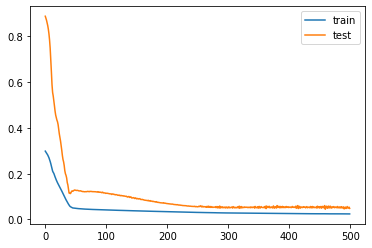

In [21]:
import tensorflow as tf
epochs = 500
batch_size = 128
validation = 0.0001

tf.keras.backend.clear_session()
tf.random.set_seed(22)
np.random.seed(22)
opt = keras.optimizers.Adam(learning_rate=0.0004)
model_enc_dec = tf.keras.models.Sequential()
model_enc_dec.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(tf.keras.layers.RepeatVector(FORECAST_RANGE))
model_enc_dec.add(tf.keras.layers.LSTM(60, activation='relu', return_sequences=True))
model_enc_dec.add(tf.keras.layers.Dense(32,activation='relu'))
model_enc_dec.add(tf.keras.layers.TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer=opt, loss='mae')
plot_model(model=model_enc_dec, show_shapes=True)
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[checkpoint_callback, rlrop_callback])
yhat = model_enc_dec.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test, yhat)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#0.16

Epoch 1/500
3/3 [==============================] - 2s 169ms/step - loss: 0.2967 - val_loss: 0.8796 - lr: 0.0100
Epoch 2/500
3/3 [==============================] - 0s 22ms/step - loss: 0.2940 - val_loss: 0.8765 - lr: 0.0100
Epoch 3/500
3/3 [==============================] - 0s 19ms/step - loss: 0.2915 - val_loss: 0.8734 - lr: 0.0100
Epoch 4/500
3/3 [==============================] - 0s 24ms/step - loss: 0.2891 - val_loss: 0.8703 - lr: 0.0100
Epoch 5/500
3/3 [==============================] - 0s 23ms/step - loss: 0.2868 - val_loss: 0.8674 - lr: 0.0100
Epoch 6/500
3/3 [==============================] - 0s 23ms/step - loss: 0.2846 - val_loss: 0.8644 - lr: 0.0100
Epoch 7/500
3/3 [==============================] - 0s 19ms/step - loss: 0.2825 - val_loss: 0.8616 - lr: 0.0100
Epoch 8/500
3/3 [==============================] - 0s 19ms/step - loss: 0.2805 - val_loss: 0.8588 - lr: 0.0100
Epoch 9/500
3/3 [==============================] - 0s 20ms/step - loss: 0.2785 - val_loss: 0.8561 - lr: 0.0100


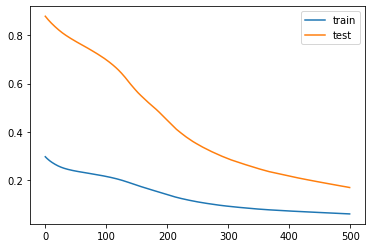

In [22]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=15, kernel_size=2, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(RepeatVector(FORECAST_RANGE))
model_cnn.add(LSTM(60, activation='relu', return_sequences=True))
model_cnn.add(TimeDistributed(Dense(100, activation='relu')))
model_cnn.add(TimeDistributed(Dense(n_features)))
model_cnn.compile(loss='mae', optimizer='sgd')
plot_model(model=model_cnn, show_shapes=True)
history = model_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[checkpoint_callback, rlrop_callback])
yhat = model_cnn.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test, yhat)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
#model_enc_dec.save_weights('mae0punto121.h5') 0.1322 con una ventana

In [24]:
batch_size = 64
buffer_size = 75
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_data = val_data.batch(batch_size).repeat() 

Epoch 1/400
100/100 [==============================] - 3s 10ms/step - loss: 0.1138 - val_loss: 0.2250 - lr: 0.0010
Epoch 2/400
100/100 [==============================] - 1s 7ms/step - loss: 0.0463 - val_loss: 0.1952 - lr: 0.0010
Epoch 3/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0376 - val_loss: 0.1748 - lr: 0.0010
Epoch 4/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0343 - val_loss: 0.1714 - lr: 0.0010
Epoch 5/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0320 - val_loss: 0.1556 - lr: 0.0010
Epoch 6/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0313 - val_loss: 0.1468 - lr: 0.0010
Epoch 7/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0286 - val_loss: 0.1569 - lr: 0.0010
Epoch 8/400
100/100 [==============================] - 1s 7ms/step - loss: 0.0282 - val_loss: 0.1426 - lr: 0.0010
Epoch 9/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0284 - val

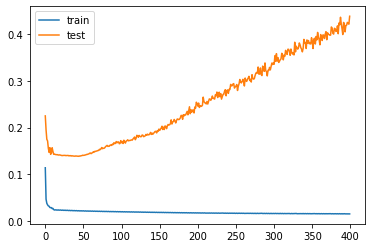

In [25]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model_testing = Sequential()
model_testing.add(Conv1D(filters=13, kernel_size=4, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_testing.add(MaxPooling1D(pool_size=2))
model_testing.add(Flatten())
model_testing.add(RepeatVector(FORECAST_RANGE))
model_testing.add(LSTM(60, activation='relu', return_sequences=True))
model_testing.add(TimeDistributed(Dense(100, activation='relu')))
model_testing.add(TimeDistributed(Dense(n_features)))
model_testing.compile(loss='mae', optimizer=opt)
plot_model(model=model_testing, show_shapes=True)
history = model_testing.fit(train_data,epochs=400,steps_per_epoch=100,validation_data=val_data,validation_steps=25,verbose=1,callbacks=[checkpoint_callback, rlrop_callback])
yhat = model_testing.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test, yhat)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
#0.12 best

Epoch 1/400
100/100 [==============================] - 3s 9ms/step - loss: 0.1141 - val_loss: 0.3655
Epoch 2/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0438 - val_loss: 0.2000
Epoch 3/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0358 - val_loss: 0.1836
Epoch 4/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0313 - val_loss: 0.1753
Epoch 5/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0339 - val_loss: 0.1923
Epoch 6/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0315 - val_loss: 0.1797
Epoch 7/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0291 - val_loss: 0.1469
Epoch 8/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0281 - val_loss: 0.1847
Epoch 9/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0283 - val_loss: 0.1583
Epoch 10/400
100/100 [==============================] - 1s 6ms/step - loss: 0.0274 - val_lo

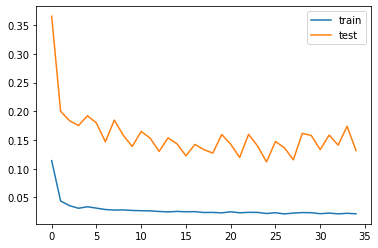

In [26]:
model_kronos = Sequential()
model_kronos.add(Conv1D(filters=13, kernel_size=4, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_kronos.add(MaxPooling1D(pool_size=2))
model_kronos.add(Flatten())
model_kronos.add(RepeatVector(FORECAST_RANGE))
model_kronos.add(LSTM(60, activation='relu', return_sequences=True))
model_kronos.add(TimeDistributed(Dense(200, activation='relu')))
model_kronos.add(TimeDistributed(Dense(n_features)))
model_kronos.compile(loss='mae', optimizer='adam')
plot_model(model=model_kronos, show_shapes=True)
history = model_kronos.fit(train_data,epochs=400,steps_per_epoch=100,validation_data=val_data,validation_steps=25,verbose=1,callbacks=[early_stopping_callback])
yhat = model_kronos.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test, yhat)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
#0.11 best

Epoch 1/200
6/6 [==============================] - 3s 111ms/step - loss: 0.1731 - val_loss: 0.7386 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 0s 21ms/step - loss: 0.1483 - val_loss: 0.5317 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 0s 21ms/step - loss: 0.1021 - val_loss: 0.3784 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 0s 23ms/step - loss: 0.0736 - val_loss: 0.2836 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0568 - val_loss: 0.2391 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0419 - val_loss: 0.1708 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 0s 21ms/step - loss: 0.0310 - val_loss: 0.1218 - lr: 0.0010
Epoch 8/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0212 - val_loss: 0.0645 - lr: 0.0010
Epoch 9/200
5/6 [========================>.....] - ETA: 0s - loss: 0.0129INFO:tensorflow:Assets written to: pat

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 974ms/step - loss: 0.0124 - val_loss: 0.0414 - lr: 0.0010
Epoch 10/200
5/6 [========================>.....] - ETA: 0s - loss: 0.0089INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 900ms/step - loss: 0.0087 - val_loss: 0.0235 - lr: 0.0010
Epoch 11/200
5/6 [========================>.....] - ETA: 0s - loss: 0.0076INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 918ms/step - loss: 0.0075 - val_loss: 0.0180 - lr: 0.0010
Epoch 12/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0065 - val_loss: 0.0206 - lr: 0.0010
Epoch 13/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0198 - lr: 0.0010
Epoch 14/200
5/6 [========================>.....] - ETA: 0s - loss: 0.0051INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 1s/step - loss: 0.0051 - val_loss: 0.0165 - lr: 0.0010
Epoch 15/200
5/6 [========================>.....] - ETA: 0s - loss: 0.0046INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 909ms/step - loss: 0.0045 - val_loss: 0.0142 - lr: 0.0010
Epoch 16/200
4/6 [===================>..........] - ETA: 0s - loss: 0.0043INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 1s/step - loss: 0.0042 - val_loss: 0.0119 - lr: 0.0010
Epoch 17/200
6/6 [==============================] - 0s 24ms/step - loss: 0.0038 - val_loss: 0.0121 - lr: 0.0010
Epoch 18/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0036 - val_loss: 0.0128 - lr: 0.0010
Epoch 19/200
4/6 [===================>..........] - ETA: 0s - loss: 0.0037INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 912ms/step - loss: 0.0035 - val_loss: 0.0093 - lr: 0.0010
Epoch 20/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0034 - val_loss: 0.0093 - lr: 0.0010
Epoch 21/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0033 - val_loss: 0.0108 - lr: 0.0010
Epoch 22/200
4/6 [===================>..........] - ETA: 0s - loss: 0.0033INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 1s/step - loss: 0.0033 - val_loss: 0.0080 - lr: 0.0010
Epoch 23/200
6/6 [==============================] - 0s 22ms/step - loss: 0.0031 - val_loss: 0.0090 - lr: 0.0010
Epoch 24/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0031 - val_loss: 0.0090 - lr: 0.0010
Epoch 25/200
4/6 [===================>..........] - ETA: 0s - loss: 0.0030INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 926ms/step - loss: 0.0029 - val_loss: 0.0063 - lr: 0.0010
Epoch 26/200
5/6 [========================>.....] - ETA: 0s - loss: 0.0026INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 1s/step - loss: 0.0027 - val_loss: 0.0062 - lr: 0.0010
Epoch 27/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0026 - val_loss: 0.0068 - lr: 0.0010
Epoch 28/200
6/6 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.0071 - lr: 0.0010
Epoch 29/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0065 - lr: 1.0000e-04
Epoch 30/200
4/6 [===================>..........] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 911ms/step - loss: 0.0025 - val_loss: 0.0061 - lr: 1.0000e-04
Epoch 31/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0064 - lr: 1.0000e-04
Epoch 32/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0064 - lr: 1.0000e-04
Epoch 33/200
5/6 [========================>.....] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 1s/step - loss: 0.0024 - val_loss: 0.0061 - lr: 1.0000e-04
Epoch 34/200
4/6 [===================>..........] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


6/6 [==============================] - 5s 912ms/step - loss: 0.0024 - val_loss: 0.0060 - lr: 1.0000e-04
Epoch 35/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0062 - lr: 1.0000e-04


mae: tf.Tensor(0.2244662, shape=(), dtype=float32)
mse: tf.Tensor(0.08196843, shape=(), dtype=float32)
mape: tf.Tensor(20.13939, shape=(), dtype=float32)


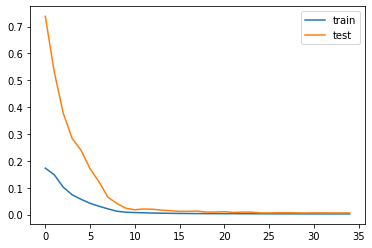

In [27]:
##no tocar
epochs = 200
batch_size = 64
validation = 0.0001
model_ades = Sequential()
model_ades.add(LSTM(120, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_ades.add(RepeatVector(FORECAST_RANGE))

model_ades.add(LSTM(64, activation='relu', return_sequences=True))
model_ades.add(Dense(32,activation='relu'))
model_ades.add(TimeDistributed(Dense(n_features)))
model_ades.compile(optimizer='adam', loss='mse')
plot_model(model=model_ades, show_shapes=True)
history = model_ades.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_ades.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test, yhat)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

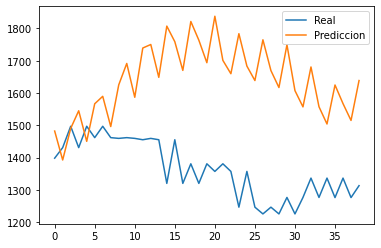

,real,prediccion
0,1398.3,1482.312744
1,1431.0,1392.738159
2,1497.1,1490.503296
3,1431.0,1545.120483
4,1497.1,1450.436523
5,1461.9,1566.781006
6,1497.1,1589.864380
7,1461.9,1496.244263
8,1459.6,1625.335327
9,1461.9,1691.622681


In [28]:
user=3
graph_predictions(y_test_inverse[:,user],yhat_inverse[:,user])
df_concat=pd.DataFrame({'real': y_test_inverse[:,user] , 'prediccion':yhat_inverse[:,user]})
df_concat.head(10)

# NUEVAS PREDICCIONES

In [29]:
import datapane as dp
def new_prediction(model, usuario,pago_mensual=3.10,descuento=0.10):
  x_input = df_cpu_pivot.iloc[len(df_cpu_pivot)-LOOK_BACK:len(df_cpu_pivot),1:].values
  x_input=scaler.transform(x_input)
  x_input = x_input.reshape((1, LOOK_BACK, len(df_cpu_pivot.columns)-1))
  yhat = model.predict(x_input, verbose=0)
  yhat = yhat.reshape(-1, yhat.shape[-1])
  yhat = pd.DataFrame(scaler.inverse_transform(yhat))
  historial,prediccion,nombre,df_all_predict=formating_samples(yhat,usuario)
  grafica_consumos=graph_comparation(historial,prediccion,nombre)
  grafica_pagos=graph_series_payment(prediccion,nombre)
  #report = input('Desea realizar un reporte? si/no')
  #generate_report(grafica_consumos,grafica_pagos,prediccion) if report.lower() =='si' else print('PROCESO FINALIZADO')
  dp.Report("Reporte de consumo de agua",
    dp.Plot(grafica_consumos, caption="Consumo de agua potable a traves del tiempo"),
    dp.Plot(grafica_pagos, caption="Comparacion de pagos para los siguientes meses"),
    dp.Table(np.round(prediccion,2), caption="Informacion consumo vs pago")
  ).save(path='report.html', open=True)
  return prediccion

In [30]:
def formating_samples(yhat,usuario,mensualidad=3.10,red_inc=0.10):
  date_predictions(yhat)
  df_2_plot = df_cpu_pivot.tail(LOOK_BACK+7)
  yhat.columns=df_2_plot.columns
  df_2_plot=df_2_plot.append(yhat,ignore_index=True)
  df_2_plot_date = df_2_plot[(df_2_plot['Date'] <= df_cpu_pivot.Date.max())]
  df_all_predictions = df_2_plot[(df_2_plot['Date'] >= df_cpu_pivot.Date.max())]
  name_user= df_all_predictions.columns[usuario]
  values_user=df_all_predictions[name_user]
  values_user=pd.DataFrame(values_user)
  values_user.iloc[0,0]=df_2_plot_date[name_user].iloc[-1]
  values_user.insert(1, 'PAGO_NORMAL', values_user*mensualidad, True) 
  values_user.insert(2,'CONSUMO_REDUCIDO',values_user[name_user]-(values_user[name_user]*red_inc), True) 
  values_user.insert(3,'PAGO_REDUCIDO',values_user['CONSUMO_REDUCIDO']*mensualidad, True) 
  values_user.insert(4,'CONSUMO_INCREMENTO',values_user[name_user]+(values_user[name_user]*red_inc), True)
  values_user.insert(5,'PAGO_INCREMENTO',values_user['CONSUMO_INCREMENTO']*mensualidad, True) 
  values_user.iloc[0,2]=df_2_plot_date[name_user].iloc[-1]
  values_user.iloc[0,4]=df_2_plot_date[name_user].iloc[-1]
  values_user.iloc[0,3]=values_user.iloc[0,1]
  values_user.iloc[0,5]=values_user.iloc[0,1]
  values_user.index= df_all_predictions.Date
  values_user = values_user.rename(columns={name_user:'CONSUMO_NORMAL'})
  return df_2_plot_date,values_user,name_user,df_all_predictions

In [31]:
def date_predictions(yhat):
  yhat.insert(0, 'Date', pd.to_datetime(df_cpu_pivot['Date'].max(), format="%Y%m%d"))
  for i in range (len(yhat)):
    yhat.iloc[i,0]=yhat.iloc[i,0]+MonthBegin(i+1)+MonthEnd(1)

In [32]:
def graph_comparation(historial,prediccion,usuario):
  trace1 = go.Scatter(
  x = historial.Date,
  y = historial[usuario],
  mode = 'lines',
  name = 'HISTORIAL',
  #fill='tozeroy',
  fillcolor = 'green'
  )
  trace2 = go.Scatter(
  x = prediccion.index,
  y = prediccion['CONSUMO_NORMAL'],
  mode = 'lines',
  name = 'NORMAL',
  #fill='tozeroy',
  fillcolor = 'green'
  )
  
  trace3 = go.Scatter(
  x = prediccion.index,
  y = prediccion['CONSUMO_REDUCIDO'],
  mode = 'lines',
  name = 'REDUCCION',
 #fill='tonexty',
  fillcolor = 'red'                   
  )
  trace4 = go.Scatter(
  x = prediccion.index,
  y = prediccion['CONSUMO_INCREMENTO'],
  mode = 'lines',
  name = 'INCREMENTO',
 #fill='tonexty',
  fillcolor = 'red'                   
  )
  layout = go.Layout(
  title = 'CONSUMO DE AGUA DEL SR: '+usuario+' PARA '+str(FORECAST_RANGE)+' MESES',
  xaxis = {'title' : 'Date'},
  yaxis = {'title' : 'Consumo (m3)'}
  )
  fig = go.Figure(data=[trace1,trace2, trace3,trace4], layout=layout)
  fig.show()
  return fig


In [33]:
def graph_series_payment(prediccion,usuario):
  fig = go.Figure()
  fig.add_trace(go.Bar(
    x=prediccion.index,
    y=prediccion['PAGO_NORMAL'],
    name='PAGO NORMAL',
    marker_color='indianred',
    text=np.round(prediccion['PAGO_NORMAL'],2)
    
  ))
  fig.add_trace(go.Bar(
    x=prediccion.index,
    y=prediccion['PAGO_REDUCIDO'],
    name='PAGO REDUCIDO',
    marker_color='lightsalmon',
    text=np.round(prediccion['PAGO_REDUCIDO'],2)
  ))
  fig.add_trace(go.Bar(
    x=prediccion.index,
    y=prediccion['PAGO_INCREMENTO'],
    name='PAGO INCREMENTO',
    marker_color='yellow',
    text= np.round(prediccion['PAGO_INCREMENTO'],2)
  ))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
  fig.update_layout(barmode='group', xaxis_tickangle=-45)
  fig.show()
  return fig

In [34]:
new_prediction(model_enc_dec,usuario=1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Report saved to ./report.html. To upload and share your report, create a free Datapane account by running `datapane signup`.
How is your experience of Datapane? Please take two minutes to answer our anonymous product survey at https://bit.ly/3lWjRlr


,CONSUMO_NORMAL,PAGO_NORMAL,CONSUMO_REDUCIDO,PAGO_REDUCIDO,CONSUMO_INCREMENTO,PAGO_INCREMENTO
Date,,,,,,
2021-07-30,1825.800000,5659.980000,1825.800000,5659.980000,1825.800000,5659.980000
2021-08-31,2154.399170,6678.637427,1938.959253,6010.773684,2369.839087,7346.501169
2021-09-30,1917.892090,5945.465479,1726.102881,5350.918931,2109.681299,6540.012026
2021-10-31,1909.976685,5920.927722,1718.979016,5328.834950,2100.974353,6513.020494


In [35]:
new_prediction(model_cnn,usuario=1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Report saved to ./report.html. To upload and share your report, create a free Datapane account by running `datapane signup`.


,CONSUMO_NORMAL,PAGO_NORMAL,CONSUMO_REDUCIDO,PAGO_REDUCIDO,CONSUMO_INCREMENTO,PAGO_INCREMENTO
Date,,,,,,
2021-07-30,1825.800000,5659.980000,1825.800000,5659.980000,1825.800000,5659.980000
2021-08-31,1885.290527,5844.400635,1696.761475,5259.960571,2073.819580,6428.840698
2021-09-30,2124.793945,6586.861230,1912.314551,5928.175107,2337.273340,7245.547354
2021-10-31,2170.578613,6728.793701,1953.520752,6055.914331,2387.636475,7401.673071


In [36]:
new_prediction(model_testing,usuario=2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Report saved to ./report.html. To upload and share your report, create a free Datapane account by running `datapane signup`.


,CONSUMO_NORMAL,PAGO_NORMAL,CONSUMO_REDUCIDO,PAGO_REDUCIDO,CONSUMO_INCREMENTO,PAGO_INCREMENTO
Date,,,,,,
2021-07-30,1539.700000,4773.070000,1539.700000,4773.070000,1539.700000,4773.070000
2021-08-31,2019.217529,6259.574341,1817.295776,5633.616907,2221.139282,6885.531775
2021-09-30,2445.649658,7581.513940,2201.084692,6823.362546,2690.214624,8339.665334
2021-10-31,2847.594971,8827.544409,2562.835474,7944.789968,3132.354468,9710.298850


In [37]:
new_prediction(model_kronos,usuario=1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Report saved to ./report.html. To upload and share your report, create a free Datapane account by running `datapane signup`.


,CONSUMO_NORMAL,PAGO_NORMAL,CONSUMO_REDUCIDO,PAGO_REDUCIDO,CONSUMO_INCREMENTO,PAGO_INCREMENTO
Date,,,,,,
2021-07-30,1825.800000,5659.980000,1825.800000,5659.980000,1825.800000,5659.980000
2021-08-31,1915.975586,5939.524316,1724.378027,5345.571885,2107.573145,6533.476748
2021-09-30,1785.462158,5534.932690,1606.915942,4981.439421,1964.008374,6088.425959
2021-10-31,1831.505859,5677.668164,1648.355273,5109.901348,2014.656445,6245.434980


In [38]:
new_prediction(model_ades,usuario=2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



Report saved to ./report.html. To upload and share your report, create a free Datapane account by running `datapane signup`.


,CONSUMO_NORMAL,PAGO_NORMAL,CONSUMO_REDUCIDO,PAGO_REDUCIDO,CONSUMO_INCREMENTO,PAGO_INCREMENTO
Date,,,,,,
2021-07-30,1539.700000,4773.070000,1539.700000,4773.070000,1539.700000,4773.070000
2021-08-31,2023.942749,6274.222522,1821.548474,5646.800270,2226.337024,6901.644774
2021-09-30,2127.856445,6596.354980,1915.070801,5936.719482,2340.642090,7255.990479
2021-10-31,2321.300781,7196.032422,2089.170703,6476.429180,2553.430859,7915.635664


# Prediccion por sectores

In [39]:
#Metodo para mapear todos los sectores dentro de la data
def append_sectors():
  sectores_users = {}
  for sector in sectores:
    name_arr_sector = sector+'_users'
    name_arr_sector = []
    [name_arr_sector.append(df_cpu_pivot.columns.get_loc(usuario)) for usuario, sector_user in dict.items() if sector == sector_user]
    if not sector in sectores_users:
      sectores_users.update({sector:name_arr_sector})
  return sectores_users

In [40]:
def new_prediction_sector(model, usuario,pago_mensual=3.10,descuento=0.10):
  x_input = df_cpu_pivot.iloc[len(df_cpu_pivot)-LOOK_BACK:len(df_cpu_pivot),1:].values
  x_input=scaler.transform(x_input)
  x_input = x_input.reshape((1, LOOK_BACK, len(df_cpu_pivot.columns)-1))
  yhat = model.predict(x_input, verbose=0)
  yhat = yhat.reshape(-1, yhat.shape[-1])
  yhat = pd.DataFrame(scaler.inverse_transform(yhat))
  historial,prediccion,nombre,df_all_predict=formating_samples(yhat,usuario)
  return prediccion,historial

In [55]:
from functools import reduce
def sum_predict_sectors(list_users):
  predicciones = []
  historial_df = []
  for i in list_users:
    prediction,historial = new_prediction_sector(model_kronos,i)
    predicciones.append(prediction)
  summatory_df = reduce(lambda x, y: x.add(y, fill_value=0), predicciones)
  [historial_df.append(historial.columns[usuario]) for usuario in list_users]
  history_values = df_cpu_pivot[historial_df]
  summatory_historial = history_values.sum(axis=1)
  summatory_historial = pd.DataFrame(summatory_historial).rename(columns={0:'HISTORIAL'})
  return summatory_df,summatory_historial

In [116]:
def graph_sectors(sec_predictions):
  layout = go.Layout(
  title = 'Consumo de agua en '+str(sectores)+' proyeccion '+str(FORECAST_RANGE)+' meses',
  xaxis = {'title' : 'Linea de tiempo'},
  yaxis = {'title' : 'Consumo (m3)'},
  hovermode='x unified'
  )
  data = []
  for clave,valor in sec_predictions.items():
    nombre= str(clave)
    clave = go.Scatter(
    x = valor[0].index,
    y = valor[0]['CONSUMO_NORMAL'],
    mode = 'lines',
    name = nombre +'_Prediccion',
    fillcolor = 'green'
    )
    name_hist= nombre+'_Historial'
    name_hist = go.Scatter(
    x = df_cpu_pivot.Date,
    y = valor[1]['HISTORIAL'],
    mode = 'lines',
    name = name_hist,
    fillcolor = 'red'
    )
    data.append(clave)
    data.append(name_hist)
  fig_sectores = go.Figure(data=data, layout=layout)
  fig_sectores.show()

In [117]:
sectores_users=append_sectors()
for clave,valor in sectores_users.items():  
  sectores_users.update({clave:sum_predict_sectors(valor)})
graph_sectors(sectores_users)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn

# REPORTES

In [44]:


def generate_report(consumos, pagos, df_user_values):
  dp.Report("Reporte de consumo de agua",
    dp.Plot(consumos, caption="Consumo de agua potable a traves del tiempo"),
    dp.Plot(pagos, caption="Comparacion de pagos para los siguientes meses"),
    dp.Table(df_user_values, caption="Informacion consumo vs pago")
  ).save(path='report.html', open=True)


# TUNING LSTM

In [45]:
import tensorflow as tf
import keras_tuner as kt

In [46]:
def model_builder(hp):
  tf.keras.backend.clear_session()

  # Initialize the Sequential API and start stacking the layers
  model = tf.keras.models.Sequential()
  model.add(Conv1D(filters=13, kernel_size=4, activation=hp.Choice("activation", ["relu","sigmoid"]), input_shape=(LOOK_BACK, n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(tf.keras.layers.RepeatVector(FORECAST_RANGE))
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.LSTM(units= hp_units, activation=hp.Choice("activation", ["relu","sigmoid"]), return_sequences=True,name='lstm_1'))
  hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(tf.keras.layers.LSTM(units= hp_units, activation=hp.Choice("activation", ["relu","sigmoid"]), return_sequences=True))
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units3 = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation=hp.Choice("activation", ["relu","sigmoid"]), name='dense_1'))
  # Add next layers
  model.add(keras.layers.Dense(units=hp_units3,activation=hp.Choice("activation", ["relu","sigmoid"])))
  model.add(tf.keras.layers.TimeDistributed(Dense(n_features)))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MAE,
                metrics=['mae'])
  return model

In [47]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_mae', # objective to optimize
max_epochs=50,
factor=3, # factor which you have seen above 
#directory='dir', # directory to save logs 
project_name='WatejConsumptionTuning')

In [48]:
#hypertuning settings
tuner.search_space_summary() 
#Output:- 

# Search space summary
# Default search space size: 2
# units (Int)
# {'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
# learning_rate (Choice)
# {'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}

Search space summary
Default search space size: 3
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [49]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)
# Perform hypertuning
tuner.search(X_train, y_train, epochs=400, validation_split=0.2, callbacks=[stop_early])

Trial 47 Complete [00h 00m 16s]
val_mae: 0.11953235417604446

Best val_mae So Far: 0.11953235417604446
Total elapsed time: 00h 05m 18s

Search: Running Trial #48

Hyperparameter    |Value             |Best Value So Far 
activation        |relu              |relu              
units             |128               |416               
learning_rate     |0.01              |0.001             
tuner/epochs      |17                |17                
tuner/initial_e...|6                 |6                 
tuner/bracket     |3                 |3                 
tuner/round       |2                 |2                 
tuner/trial_id    |59ee0cc216006ee...|bdab1a47c92e41e...

Epoch 7/17


KeyboardInterrupt: ignored

In [ ]:
best_hp=tuner.get_best_hyperparameters()[0]

In [ ]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
plot_model(model=h_model, show_shapes=True)
history=h_model.fit(X_train, y_train, epochs=300, validation_split=0.2)
yhat = h_model.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test, yhat)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()